In [10]:
import tensorflow
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print('tensorflow: %s' % tensorflow.__version__)
print('keras: %s' % keras.__version__)

tensorflow: 2.9.2
keras: 2.9.0


In [11]:
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from tensorflow.keras.layers import concatenate
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
from os import listdir
from pickle import dump
from keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
from keras.models import Model

def extract_features(address,filenames):
    model = VGG19()
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    print(model.summary())
    features = dict()
    for name in filenames:
        filename = address + name
        image = load_img(filename, target_size = (224,224))
        image = img_to_array(image)
        image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
        image = preprocess_input(image)
        feature = model.predict(image, verbose = 0)
        image_id = name.split('.')[0]
        features[image_id] = feature
        #print('>%s' % name)
    return features
    
directory = '/content/drive/My Drive/flickr8k/'

In [14]:
image_dataset = listdir(directory + 'images')

train_size = int(0.9*len(image_dataset))
test_size = len(image_dataset) - train_size
train_data = image_dataset[:train_size]
test_data = image_dataset[train_size:]

In [15]:
train_features =  extract_features(directory + 'images/', train_data)
test_features = extract_features(directory + 'images/', test_data)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [16]:
dump(train_features, open('/content/drive/My Drive/flickr8k/features.pkl','wb'))
#with open('/content/drive/My Drive/flickr8k/features.pkl', 'wb') as outfile:
#    dump(features, outfile)
#print('features stored in features.pkl file')

In [17]:
#import pickle
#features = None
#with open('/content/drive/My Drive/flickr8k/features.pkl', 'rb') as infile:
#    features = pickle.load(infile)
#print('features read from features.pkl file')
#dir = '/content/drive/My Drive/flickr8k/'

In [18]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/flickr8k/captions.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [19]:
import string
import re

def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions):
    table = str.maketrans('','',string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [re.sub(r'[^\w\s]', '', w) for w in desc]
            desc = [word for word in desc if len(word) > 1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] = ' '.join(desc)

def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

filename = '/content/drive/My Drive/flickr8k/captions.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc)
print('Loaded: %d' % len(descriptions))
clean_descriptions(descriptions)
voc = to_vocabulary(descriptions)
print('Vocabulary size: %d' % len(voc))
save_descriptions(descriptions, '/content/drive/My Drive/flickr8k/descriptions.txt')

Loaded: 8092
Vocabulary size: 8680


In [20]:
print(len(descriptions))

8092


In [21]:
from pickle import load
 
# DOUBT CELLL
# load doc into memory
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
 # skip empty lines
        if len(line) < 1:
            continue
 # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions
 
# load photo features
def load_photo_features(filename, dataset):
 # load all features
    all_features = load(open(filename, 'rb'))
 # filter features
    features = {k: all_features[k] for k in dataset}
    return features
 
# load training dataset (6K)
#filename = directory + 'Flickr8k_text/Flickr_8k.trainImages.txt'
#print(filename)
#train = load_set(filename)
#print('Dataset: %d' % len(train))
# descriptions
#train_descriptions = load_clean_descriptions(directory + 'descriptions.txt', train)
#print('Descriptions: train=%d' % len(train_descriptions))
# photo features
#train_features = load_photo_features(directory + 'features.pkl', train)
#print('Photos: train=%d' % len(train_features))

In [28]:
def modify_descriptions(img_names, img_descs):
    desc_dict = dict()
    for key, desc in img_descs.items():
        if key in img_names:
            modified_desc = list()
            for i in range(len(desc)):
                modified_desc.append('startseq ' + desc[i] + ' endseq')
            desc_dict[key] = modified_desc
    return desc_dict

train_image_names = [i.split('.')[0] for i in train_data]
test_image_names = [i.split('.')[0] for i in test_data]

train_descriptions = modify_descriptions(train_image_names, descriptions)    
test_descriptions = modify_descriptions(test_image_names, descriptions)

In [34]:
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import pad_sequences


def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
  
def create_tokenizer(desc):
    lines = to_lines(desc)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

def max_length_function(desc):
    lines = to_lines(desc)
    return max(len(d.split()) for d in lines)

def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = [], [], []
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

Vocabulary Size: 8254


In [35]:
def define_model(vocab_size, max_length):
    input1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(input1)
    fe2 = Dense(256, activation='relu')(fe1)
    input2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation = 'relu')(decoder1)
    outputs = Dense(vocab_size, activation = 'softmax')(decoder2)
    model = Model(inputs=[input1, input2], outputs=outputs)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
    print(model.summary())
    return model

In [36]:
def data_generator(descriptions, photos, tokenizer, max_length):
    while 1:
        for key, desc_list in descriptions.items():
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
            yield [[in_img, in_seq], out_word]

In [37]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1

# Maximum number of words in a line or sentence
max_length = max_length_function(train_descriptions)

# Defining the final Model
model = define_model(vocab_size, max_length)

# train the model, run epochs manually and save after each epoch
epochs = 1
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(generator, epochs=5, steps_per_epoch=steps, verbose=1)
    model.save(directory + 'model_' + str(i) + '.h5')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 33, 256)      2113024     ['input_7[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 4096)         0           ['input_6[0][0]']                
                                                                                            

In [38]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu


def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen = max_length)
        yhat = model.predict([photo,sequence], verbose = 0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text
  
def evaluate_model(model, desc, photos, tokenizer, max_length):
    actual, pred = [], []
    for key, desc_list in desc.items():
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        references = [d.split() for d in desc_list]
        actual.append(references)
        pred.append(yhat.split())
    print('BLEU-1: %f' % corpus_bleu(actual, pred, weights=(1.0,0,0,0)))
    print('BLEU-2: %f' % corpus_bleu(actual, pred, weights=(0.5,0.5,0,0)))
    print('BLEU-3: %f' % corpus_bleu(actual, pred, weights=(0.3,0.3,0.3,0)))
    print('BLEU-4: %f' % corpus_bleu(actual, pred, weights=(0.25,0.25,0.25,0.25)))

In [40]:
filename = directory + 'model_0.h5'
model = load_model(filename)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.553310
BLEU-2: 0.308120
BLEU-3: 0.214481
BLEU-4: 0.100667


In [41]:

#Generate Captions for a Fresh Image

from pickle import load
from numpy import argmax
#from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg19 import VGG19
#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.models import load_model
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

# extract features from each photo in the directory
#fig = plt.figure(figsize=(10,20))

def extract_features_filename(filename):
		model = VGG19()
		model.layers.pop()
		model = Model(inputs=model.inputs, outputs = model.layers[-2].output)
		img = load_img(filename, target_size = (224,224))
		img = img_to_array(img)
		img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
		img = preprocess_input(img)
		feature = model.predict(img, verbose = 0)
		return feature	  

#max_length = 34
model = load_model(directory + 'model_0.h5')

In [42]:
true_caps = []
for j in test_descriptions.keys():
		p = str(test_descriptions[j][0]).split()[1:-1]
		true_caps.append(p)
print(true_caps[:5])

[['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way'], ['black', 'dog', 'and', 'spotted', 'dog', 'are', 'fighting'], ['little', 'girl', 'covered', 'in', 'paint', 'sits', 'in', 'front', 'of', 'painted', 'rainbow', 'with', 'her', 'hands', 'in', 'bowl'], ['man', 'lays', 'on', 'bench', 'while', 'his', 'dog', 'sits', 'by', 'him'], ['man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something']]


Generated Caption :  startseq man in red shirt is standing on the street endseq
True Caption      :  startseq child in pink dress is climbing up set of stairs in an entry way endseq
BLEU Score        :  0.8408964152537145


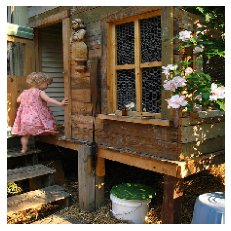



Generated Caption :  startseq dog is running through the grass endseq
True Caption      :  startseq black dog and spotted dog are fighting endseq
BLEU Score        :  1.0


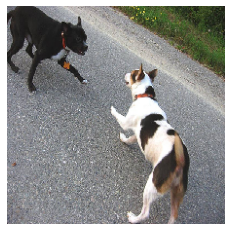



Generated Caption :  startseq little girl in red shirt is playing with her dog endseq
True Caption      :  startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
BLEU Score        :  0.5969491792019646


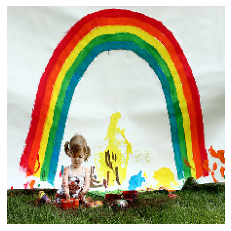



Generated Caption :  startseq dog is running through the grass endseq
True Caption      :  startseq man lays on bench while his dog sits by him endseq
BLEU Score        :  1.0


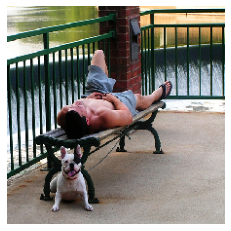



Generated Caption :  startseq man in red shirt is standing in front of the water endseq
True Caption      :  startseq man in an orange hat starring at something endseq
BLEU Score        :  0.9306048591020996


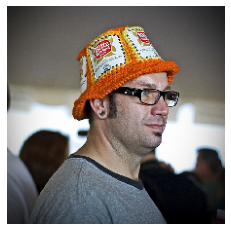



Generated Caption :  startseq little girl in red shirt is playing with her dog endseq
True Caption      :  startseq child playing on rope net endseq
BLEU Score        :  0.5969491792019646


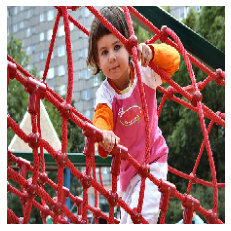



Generated Caption :  startseq dog is running through the grass endseq
True Caption      :  startseq black and white dog is running in grassy garden surrounded by white fence endseq
BLEU Score        :  1.0


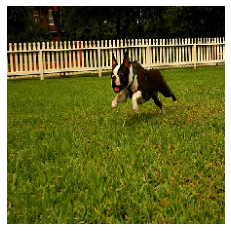



Generated Caption :  startseq dog is running through the snow endseq
True Caption      :  startseq dog shakes its head near the shore red ball next to it endseq
BLEU Score        :  1.0


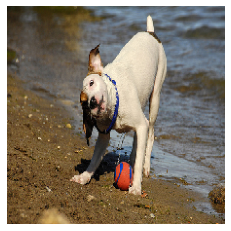

In [45]:
count = 0
for i in test_descriptions.keys():
		photo = extract_features_filename(directory + 'images/' + i + '.jpg')
		plt.plot()
		img = load_img(directory + 'images/' + i + '.jpg', target_size = (224,224))
		plt.imshow(img)
		# generate description
		description = generate_desc(model, tokenizer, photo, max_length)
		print("Generated Caption : ", description)
		print("True Caption      : ", test_descriptions[i][0])
		#print(test_descriptions[i][0].dtype())
		pred_desc = str(description).split()
		bleu = sentence_bleu(true_caps,pred_desc[1:-1])
		print('BLEU Score        : ', bleu)
		plt.axis('off')
		count += 1
		if count == 8:
				break
		plt.show()
		print('\n')

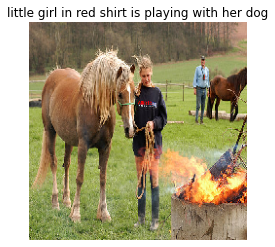

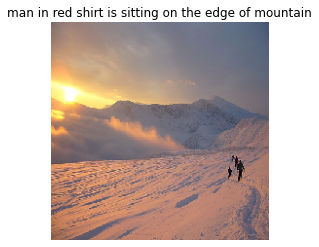

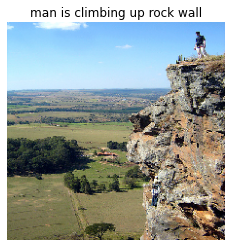

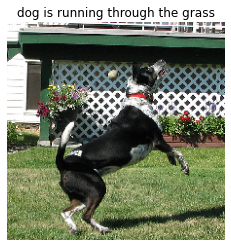

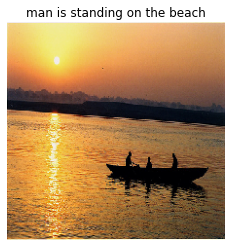

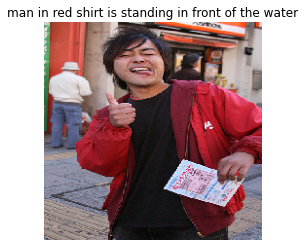

In [58]:
random_test = ['test1.jpg','test2.jpg','test3.jpg','test4.jpg','test5.jpg','test7.jpg']

for i in random_test:
    photo = extract_features_filename(directory + i)
    plt.plot()
    img = load_img(directory + i, target_size = (224,224))
    plt.imshow(img)
    desc = generate_desc(model, tokenizer, photo, max_length)
    pred_desc = str(desc).split()[1:-1]
    cap_generated = ' '.join(pred_desc)
    plt.title(cap_generated)
    plt.axis('off')
    plt.show()
    print('\n\n')